**Objetivo:** Estudar como as linhas espectrais da molécula de HCl na banda 2-0 se alargam em função da temperatura.


 **1.** Verificar se os espectros simulados pelo Hitran provê os mesmos coeficientes de auto-alargamento em função da pressão estudados durante a graduação.

 **2.** Simular espectros com as mesmas pressões, mas em temperaturas diferentes e verificar o que acontece com os coeficientes de auto-alargamento em cada temperatura
 
 **3.** Fixar uma pressão e verificar como esse coeficiente varia somente na temperatura.

 **4.** Estudar uma maneira de determinar a dependência entre pressão e temperatura.

 **5.** Modelar matematicamente em termos de temperatura e pressão

 **6.** Validar esse modelo em dados reais

 **7.** Desenvolver modelos de Machine Learning para processamento de espectros 

# Importando pacotes

In [1]:
import sys
sys.path.append("../src")

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.express as px

from BroadeningProcessing import broadeningprocessing




mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['figure.figsize'] = (12,6)

# Simulando e processando espectros

Uma banda espectral é formada por linhas/raias espectrais, essas linhas são provenientes das transições de energias rotacionais em uma molécula. Essas transições podem ser categorizadas por Ramas denominadas por rama R, rama P ou  rama Q. No caso da banda 2-0 do HCl, temos somente as Ramas R e P. Cada linha, além da categorização da rama, tem também um valor de J associado, para o HCl temos:

R = 0, 1, 2, 3, 4...

P = 1, 2, 3, 4...

Além do valor de J, podemos introduzir uma outra variável denotada por m, onde

m = -J, se for rama P,

m = J + 1, se for rama R

Ao simularmos um espectro, é necessário aplicarmos um pré-processamento para organizarmos os dados obtidos, visamos nessa parte categorizar as transições (R/P) e definir seus valores de J e m. 

Após a organização das linhas, precisaremos obter os coeficientes de auto-alargamento, e para isso será necessário obter a largura de cada raia espectral. Esse parâmetro será obtido mediante o ajuste não linear de cada linha espectral pelo perfil de Voigt. No meu tcc eu demonstrei que o perfil de Voigt é o melhor perfil que se ajusta nas linhas do HCl, além disso, o perfil de Voigt é um grande coringa, pois leva em consideração os efeitos simultâneos de colisão e efeito doppler.

**Tarefas:**

**1.** Identificar as raias espectrais

**2.** Categorizar as linhas em rama P ou rama R

**3.** Indicar a numeração de cada linha referente  a sua rama

**4.** Separar a raia do espectro.

**5.** Ajustar a linha utilizando o perfil de Voigt.

**6.** Armazenar todos os parâmetros obtidos do ajuste em um dataset.

**7.** Fazer isso para espectros em diferentes pressões e temperaturas.


obs: As simulações dos espectros, atribuição de raias e ajuste das linhas para obtenção de parâmetros foi feito através do script /src/main.py e se encontra no diretório /database

# Carregando dataset com os parâmetros de cada linha

In [2]:
lines35 = pd.read_csv('../database/lines_h35cl.csv')

# Breve EDA $$H^{35}Cl$$

In [3]:
lines35.head()

,wavenumber,absorption,branch,j,m,pressure,temperature,evals,npoints,r2,...,center,center_std,sigma,sigma_stderr,gamma,gamma_stderr,fwhm,fwhm_stderr,height,height_stderr
0,5341.321654,0.022379,P,12,-12,0.1,295,31,173,0.999966,...,5341.321453,0.000022,0.004680,0.000023,0.007745,0.000022,0.021450,0.000019,0.022390,0.000015
1,5374.629654,0.060875,P,11,-11,0.1,295,26,194,0.999978,...,5374.629237,0.000017,0.004733,0.000021,0.008847,0.000018,0.023317,0.000017,0.060964,0.000031
2,5406.878654,0.148620,P,10,-10,0.1,295,26,215,0.999999,...,5406.878677,0.000004,0.004874,0.000005,0.009849,0.000004,0.025220,0.000004,0.148781,0.000017
3,5438.054654,0.296448,P,9,-9,0.1,295,25,256,0.998283,...,5438.054978,0.000144,0.000341,0.002717,0.013728,0.000159,0.027482,0.000173,0.299677,0.001315
4,5468.143654,0.499196,P,8,-8,0.1,295,71,313,0.999985,...,5468.143806,0.000013,0.005680,0.000025,0.014613,0.000019,0.034700,0.000017,0.501097,0.000173


In [4]:
# sem valores nulos
lines35.isna().sum()

wavenumber          0
absorption          0
branch              0
j                   0
m                   0
pressure            0
temperature         0
evals               0
npoints             0
r2                  0
amplitude           0
amplitude_stderr    0
center              0
center_std          0
sigma               0
sigma_stderr        0
gamma               0
gamma_stderr        0
fwhm                0
fwhm_stderr         0
height              0
height_stderr       0
dtype: int64

In [5]:
# sem valores duplicados
lines35.duplicated().sum()

np.int64(0)

In [6]:
# Em muitos trabalhos utiliza-se a meia largura à meia altura (hwhm) ao invés da largura total à meia altura (fhwm)
# hwhm = fwhm/2

lines35['hwhm'] = lines35['fwhm'] / 2 


print(f" {lines35.shape[0]} linhas foram ajustadas com {lines35.shape[1]} parâmetros obtidos, são eles:\n")
for index, param in enumerate(lines35.columns):
    print(f"{index} - {param}")

 771 linhas foram ajustadas com 23 parâmetros obtidos, são eles:

0 - wavenumber
1 - absorption
2 - branch
3 - j
4 - m
5 - pressure
6 - temperature
7 - evals
8 - npoints
9 - r2
10 - amplitude
11 - amplitude_stderr
12 - center
13 - center_std
14 - sigma
15 - sigma_stderr
16 - gamma
17 - gamma_stderr
18 - fwhm
19 - fwhm_stderr
20 - height
21 - height_stderr
22 - hwhm


In [7]:
# As mesmas pressões foram reproduzidas em diferentes temperaturas 

lines35.groupby('temperature')['pressure'].unique().to_frame()

,pressure
temperature,
295,"[0.1, 0.2, 0.4, 0.6, 0.8, 1.0]"
300,"[0.1, 0.2, 0.4, 0.6, 0.8, 1.0]"
315,"[0.1, 0.2, 0.4, 0.6, 0.8, 1.0]"
350,"[0.1, 0.2, 0.4, 0.6, 0.8, 1.0]"
373,"[0.1, 0.2, 0.4, 0.6, 0.8, 1.0]"


## **Análise dos ajustes das raias**

Objetivo: Quantificar a qualidade dos ajustes das raias espectrais

In [8]:
lines35['r2'].describe()

count    771.000000
mean       0.998851
std        0.005664
min        0.938528
25%        0.999841
50%        0.999966
75%        0.999997
max        1.000000
Name: r2, dtype: float64

**Insight:** 

Ajustes bons com R² superiores à 0.9. O pior ajuste teve um R² de 0.938 e o melhor ajuste teve o R² máximo. Em mediana tivemos um R² de 0.9999 e 0.9988 em média. 

25% das linhas tiveram seu R² abaixo de 0.999841.

O valor da média é influenciado para baixo devido aos poucos exemplos com R² menores que 0.99.

Em suma, os ajustes ficaram muito bons.



## Análise do alargamento das linhas espectrais

<Axes: xlabel='hwhm', ylabel='Density'>

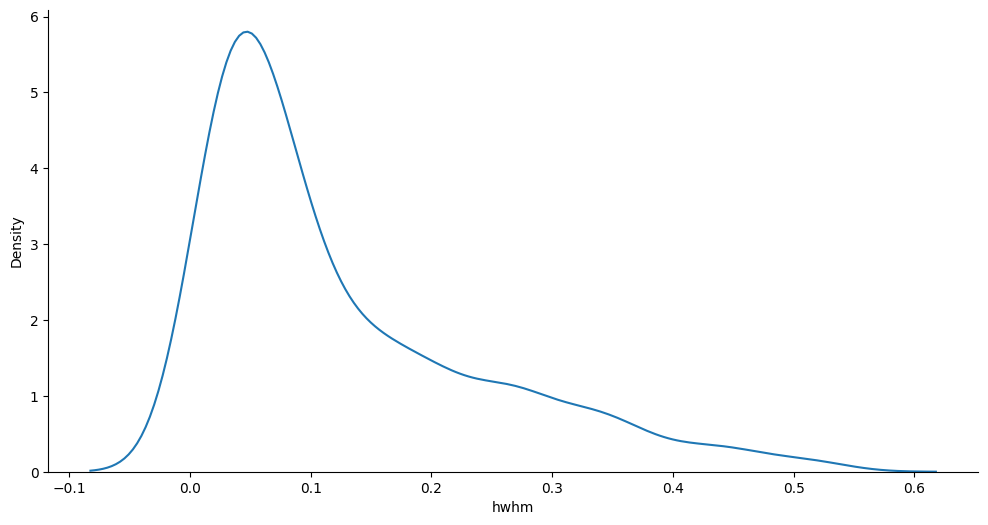

In [9]:
lines35['hwhm'].describe()

sns.kdeplot(data = lines35, x='hwhm')

In [10]:
sb = lines35.query('temperature == 295')[['branch','m','pressure','hwhm']]

<Axes: xlabel='pressure', ylabel='hwhm_diff'>

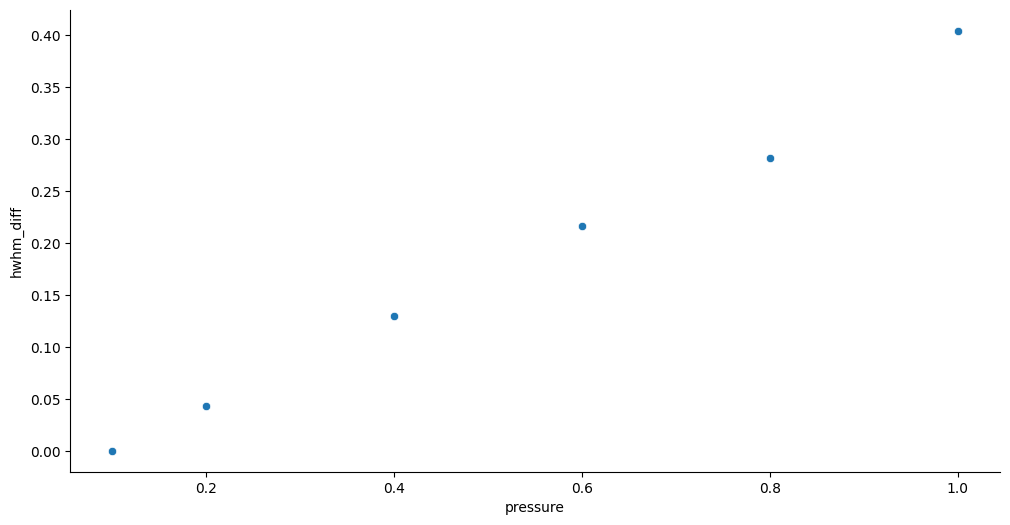

In [13]:
aux = sb.query(f'm == -2').reset_index(drop=True).sort_values(by='pressure')

aux['hwhm_diff'] = aux['hwhm'] - aux.loc[0,'hwhm']

sns.scatterplot(data = aux, x='pressure',y='hwhm_diff')